# UNet FCNs for 3D Object Detection

Dataset: Lyft 3D Object Detection Challenge on [Kaggle](https://www.kaggle.com/c/3d-object-detection-for-autonomous-vehicles)

Model: UNet FCN

In [73]:
#magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
#imports

from utils.transformations import *
from utils.boxes import *

import multiprocessing
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.makedirs('./objects', exist_ok=True)
import glob
import datetime
import functools
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

import numpy as np
import cv2 as cv
import pandas as pd
from PIL import Image
import scipy
import scipy.ndimage
import scipy.special
import matplotlib.pyplot as plt

In [99]:
from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import *
from lyft_dataset_sdk.utils.geometry_utils import *
from lyft_dataset_sdk.utils.map_mask import *
from lyft_dataset_sdk.utils.data_classes import *

In [4]:
data_path = Path('data')
train = data_path/'train_data'

In [5]:
#LyftDataset??
data = LyftDataset(data_path = '.', json_path = str(train))

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 15.9 seconds.
Reverse indexing ...
Done reverse indexing in 3.5 seconds.


In [6]:
# get mean-height of all categories. useful for bbox later
data.list_categories()

Category stats
animal                      n=  186, width= 0.36±0.12, len= 0.73±0.19, height= 0.51±0.16, lw_aspect= 2.16±0.56
bicycle                     n=20928, width= 0.63±0.24, len= 1.76±0.29, height= 1.44±0.37, lw_aspect= 3.20±1.17
bus                         n= 8729, width= 2.96±0.24, len=12.34±3.41, height= 3.44±0.31, lw_aspect= 4.17±1.10
car                         n=534911, width= 1.93±0.16, len= 4.76±0.53, height= 1.72±0.24, lw_aspect= 2.47±0.22
emergency_vehicle           n=  132, width= 2.45±0.43, len= 6.52±1.44, height= 2.39±0.59, lw_aspect= 2.66±0.28
motorcycle                  n=  818, width= 0.96±0.20, len= 2.35±0.22, height= 1.59±0.16, lw_aspect= 2.53±0.50
other_vehicle               n=33376, width= 2.79±0.30, len= 8.20±1.71, height= 3.23±0.50, lw_aspect= 2.93±0.53
pedestrian                  n=24935, width= 0.77±0.14, len= 0.81±0.17, height= 1.78±0.16, lw_aspect= 1.06±0.20
truck                       n=14164, width= 2.84±0.32, len=10.24±4.09, height= 3.44±0.62, lw_asp

In [7]:
mean_heights = {
    'animal': 0.51,
    'bicycle': 1.44,
    'bus' : 3.44,
    'car': 1.72,
    'emergency_vehicle': 2.39,
    'motorcycle': 1.59,
    'other_vehicle': 3.23,
    'pedestrian': 1.78,
    'truck': 3.44
}

In [8]:
classes = list(mean_heights.keys())

In [9]:
records = [(data.get('sample', record['first_sample_token'])['timestamp'], record) for record in data.scene]

In [10]:
entries = []
for ts, record in sorted(records):
    start = data.get('sample', record['first_sample_token'])['timestamp'] / 10000000
    token = record['token']
    name = record['name']
    date = datetime.datetime.utcfromtimestamp(start)
    first_sample_token = record['first_sample_token']
    car = "-".join(name.split("-")[:2])
    entries.append((car, name, date, token, first_sample_token))

In [11]:
cols = ['car', 'scene', 'date', 'scene_token', 'first_sample_token']
d = pd.DataFrame(entries, columns = cols)

In [12]:
d.head()

,car,scene,date,scene_token,first_sample_token
0,host-a007,host-a007-lidar0-1230485630199365106-123048565...,1974-11-25 20:57:23.030199,473093b48a7cb78d05e36245fd2dbd12d66ded7dab1ecb...,c7f7de87ec90c8993d4e7d5463208d2aa9f5ecde671960...
1,host-a007,host-a007-lidar0-1230672860198383106-123067288...,1974-11-26 02:09:26.030119,c62b89d6ae60528c00b8a520bfa16799147f5c2dccbe1e...,07889e50d51717e829cbcb4800e6cb2ce08bdabe92440c...
2,host-a007,host-a007-lidar0-1230936221299185986-123093624...,1974-11-26 09:28:22.140202,694dc7b4629151745d3e1b228b1d6653b0fc1ded12aa8d...,83ce1da2c4b37ca88a102928f01512acf8f55ac7207d04...
3,host-a007,host-a007-lidar0-1231093036199514746-123109306...,1974-11-26 13:49:43.630226,8ed3a2f8cf6e01e0d2c0df7db77839f468ed2aa48b6511...,dddda3940f002b0fa6c495a5ad6d5c4a4c8253aa5ed189...
4,host-a009,host-a009-lidar0-1231200854198312986-123120087...,1974-11-26 16:49:25.430126,a05a48966fbc46666be116a79222374c6c79e6fa930c2f...,8990abea0a146b047a04bc6ed303b16cb1c62cca49bf58...


In [13]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 5 columns):
car                   180 non-null object
scene                 180 non-null object
date                  180 non-null datetime64[ns]
scene_token           180 non-null object
first_sample_token    180 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 7.2+ KB


In [14]:
car_count = d.groupby("car")['scene_token'].count()
car_count

car
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64

# Data Split

Split data into training and validation sets

In [15]:
d[cols].nunique()

car                    12
scene                 180
date                  180
scene_token           180
first_sample_token    180
dtype: int64

There are 12 unique values for the host cars, and every other data is non-unique as 180 is the total number of records. We can split the dataset over any of the given indexes, but since `car` has the smallest number of values, we'll go with that

In [16]:
valid_cars = ['host-a0012', 'host-a101', 'host-a102']

valid_df = d[d['car'].isin(valid_cars)]
train_df = d[~d.index.isin(valid_df.index)]

In [17]:
#counts obtained from above
assert len(train_df) == 148
assert len(valid_df) == 32

# Sample

In [18]:
first_sample_token = train_df.first_sample_token.values[0]
sample = data.get("sample", first_sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = data.get("sample_data", sample_lidar_token)
lidar_filepath = data.get_sample_data_path(sample_lidar_token)

ego_pose = data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                    inverse=False)

In [19]:
pointCloud = LidarPointCloud.from_file(lidar_filepath)
pointCloud.transform(car_from_sensor)

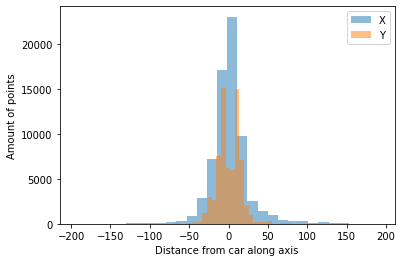

In [21]:
plt.hist(pointCloud.points[0], alpha = 0.5, bins = 30, label = "X")
plt.hist(pointCloud.points[1], alpha = 0.5, bins = 30, label = "Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [24]:
tm = transformation2voxel(shape = (100,100,4), size = (0.5,0.5,0.5), offset = (0,0,0.5))
p = transform(np.array([[10, 10, 0, 0, 0], [10, 5, 0, 0, 0],[0, 0, 0, 2, 0]], dtype = np.float32), tm)
print(p) 

[[70. 70. 50. 50. 50.]
 [70. 60. 50. 50. 50.]
 [ 3.  3.  3.  7.  3.]]


In [25]:
voxel_size = (0.4,0.4,1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

In [28]:
bev = createPointCloud(pointCloud.points, bev_shape, size = voxel_size, z_offset = z_offset)

bev = normalizeVoxels(bev)

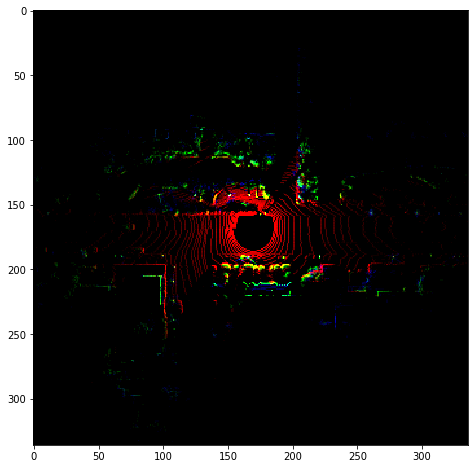

In [29]:
plt.figure(figsize=(16,8))
plt.imshow(bev)
plt.show()

In [30]:
boxes = data.get_boxes(sample_lidar_token)

target_im = np.zeros(bev.shape[:3], dtype=np.uint8)

In [46]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor
        
def draw_boxes(im, size, boxes, classes, z_offset = 0.0):
    for box in boxes:
        corners = box.bottom_corners()
        corners_voxel = car2voxel(corners, im.shape, size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

In [51]:
# boxes = moveBoxesToCar(boxes, ego_pose)
# boxes = scaleBoxes(boxes, 0.8)
# drawBoxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

# plt.figure(figsize = (8,8))
# plt.imshow((target_im > 0).astype(np.float32), cmap = 'Set2')
# plt.show()
# move_boxes_to_car_space(boxes, ego_pose)
# scale_boxes(boxes, 0.8)
# draw_boxes(target_im, voxel_size, boxes, classes, z_offset=z_offset)

# plt.figure(figsize=(8,8))
# plt.imshow((target_im > 0).astype(np.float32), cmap='Set2')
# plt.show()

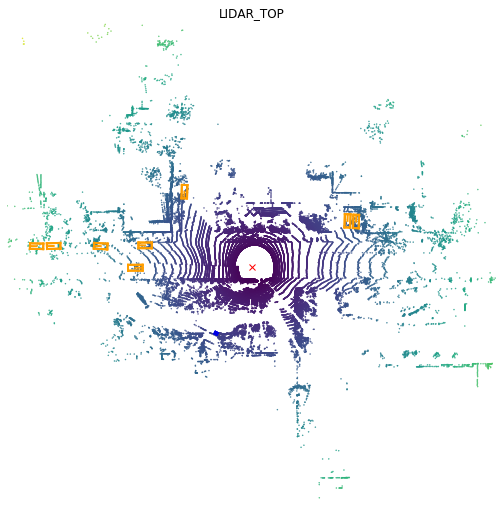

In [50]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
    
# Don't worry about it being mirrored.
visualize_lidar_of_sample(first_sample_token)

In [52]:
del bev, pointCloud, boxes

In [53]:
voxel_size = (0.4, 0.4, 1.5)
z_offset = -2.0
bev_shape = (336, 336, 3)

box_scale = 0.8

In [54]:
train_data_folder = os.path.join('./objects', "bev_train_data")
validation_data_folder = os.path.join('./objects', "./bev_validation_data")

In [64]:
NUM_WORKERS = os.cpu_count() * 3

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = data.get("sample_data", sample_lidar_token)
        lidar_filepath = data.get_sample_data_path(sample_lidar_token)

        ego_pose = data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = createPointCloud(lidar_pointcloud.points, bev_shape, size = voxel_size, z_offset=z_offset)
        bev = normalizeVoxels(bev)

        
        boxes = data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only

        cv.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        
        sample_token = sample["next"]

for df, data_folder in [(train_df, train_data_folder), (valid_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values

    os.makedirs(data_folder, exist_ok=True)
    
    process_func = functools.partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = multiprocessing.Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()
    del pool

Preparing data into ./objects/bev_train_data using 24 workers


Failed to load Lidar Pointcloud for 9cb04b1a4d476fd0782431764c7b55e91c6dbcbc6197c3dab3e044f13d058011: cannot reshape array of size 265728 into shape (5):

Preparing data into ./objects/./bev_validation_data using 24 workers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


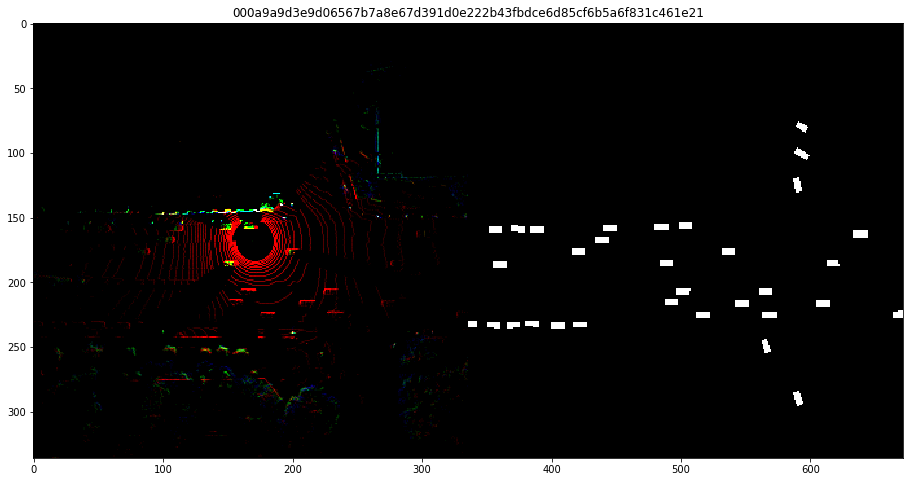

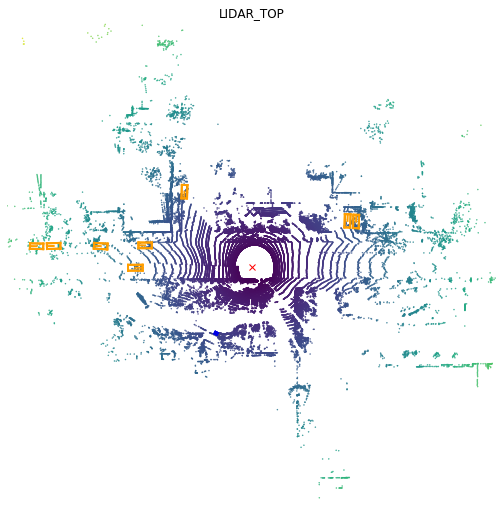

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths)
    
im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

target_as_rgb = np.repeat(target[...,None], 3, 2)
# Transpose the input volume CXY to XYC order, which is what matplotlib requires.
plt.imshow(np.hstack((im.transpose(1,2,0)[...,:3], target_as_rgb)))
plt.title(sample_token)
plt.show()

visualize_lidar_of_sample(first_sample_token)

In [66]:
class UNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        n_classes=2,
        depth=5,
        wf=6,
        padding=False,
        batch_norm=False,
        up_mode='upconv',
    ):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(
                UNetConvBlock(prev_channels, 2 ** (wf + i), padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(
                UNetUpBlock(prev_channels, 2 ** (wf + i), up_mode, padding, batch_norm)
            )
            prev_channels = 2 ** (wf + i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path) - 1:
                blocks.append(x)
                x = F.max_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i - 1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_size, out_size, kernel_size=1),
            )

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[
            :, :, diff_y : (diff_y + target_size[0]), diff_x : (diff_x + target_size[1])
        ]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out

In [67]:
def get_unet_model(in_channels=3, num_output_classes=2):
    model = UNet(in_channels=in_channels, n_classes=num_output_classes, wf=5, depth=4, padding=True, up_mode='upsample')
    
    # Optional, for multi GPU training and inference
    model = nn.DataParallel(model)
    return model

In [68]:
def visualize_predictions(input_image, prediction, target, n_images=2, apply_softmax=True):
    """
    Takes as input 3 PyTorch tensors, plots the input image, predictions and targets.
    """
    # Only select the first n images
    prediction = prediction[:n_images]
    target = target[:n_images]
    input_image = input_image[:n_images]

    prediction = prediction.detach().cpu().numpy()
    if apply_softmax:
        prediction = scipy.special.softmax(prediction, axis=1)
    class_one_preds = np.hstack(1-prediction[:,0])

    target = np.hstack(target.detach().cpu().numpy())

    class_rgb = np.repeat(class_one_preds[..., None], 3, axis=2)
    class_rgb[...,2] = 0
    class_rgb[...,1] = target

    
    input_im = np.hstack(input_image.cpu().numpy().transpose(0,2,3,1))
    
    if input_im.shape[2] == 3:
        input_im_grayscale = np.repeat(input_im.mean(axis=2)[..., None], 3, axis=2)
        overlayed_im = (input_im_grayscale*0.6 + class_rgb*0.7).clip(0,1)
    else:
        input_map = input_im[...,3:]
        overlayed_im = (input_map*0.6 + class_rgb*0.7).clip(0,1)

    thresholded_pred = np.repeat(class_one_preds[..., None] > 0.5, 3, axis=2)

    fig = plt.figure(figsize=(12,26))
    plot_im = np.vstack([class_rgb, input_im[...,:3], overlayed_im, thresholded_pred]).clip(0,1).astype(np.float32)
    plt.imshow(plot_im)
    plt.axis("off")
    plt.show()

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)

In [70]:
batch_size = 8
epochs = 15 # Note: We may be able to train for longer and expect better results, the reason this number is low is to keep the runtime short.

model = get_unet_model(num_output_classes=len(classes)+1)
model = model.to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)

all_losses = []

Epoch 1


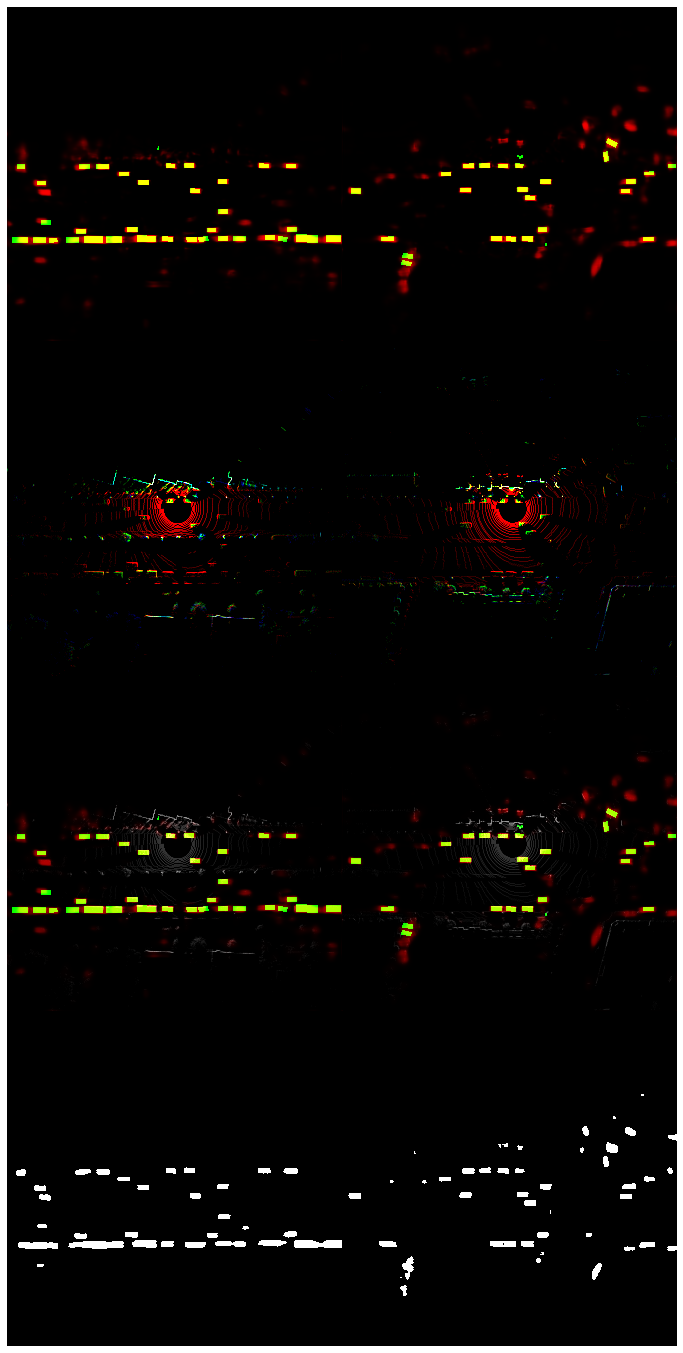


Loss: 0.051616695
Epoch 2


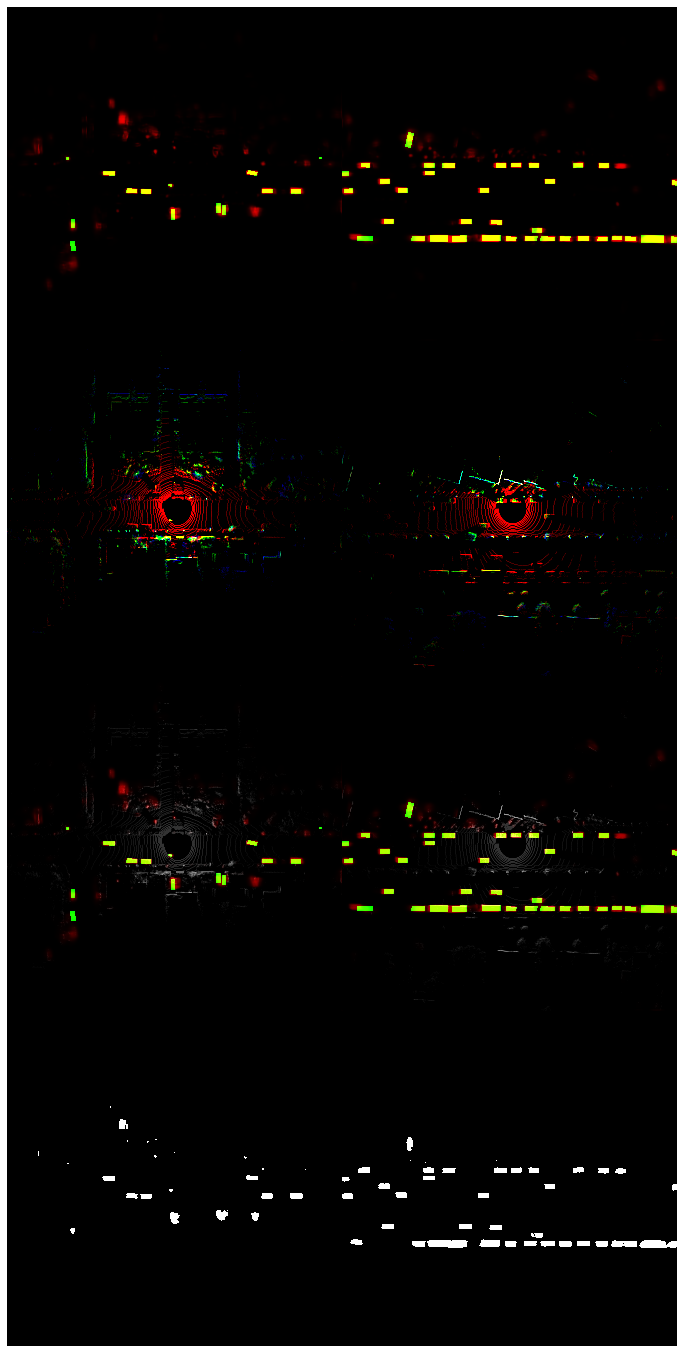


Loss: 0.040652562
Epoch 3


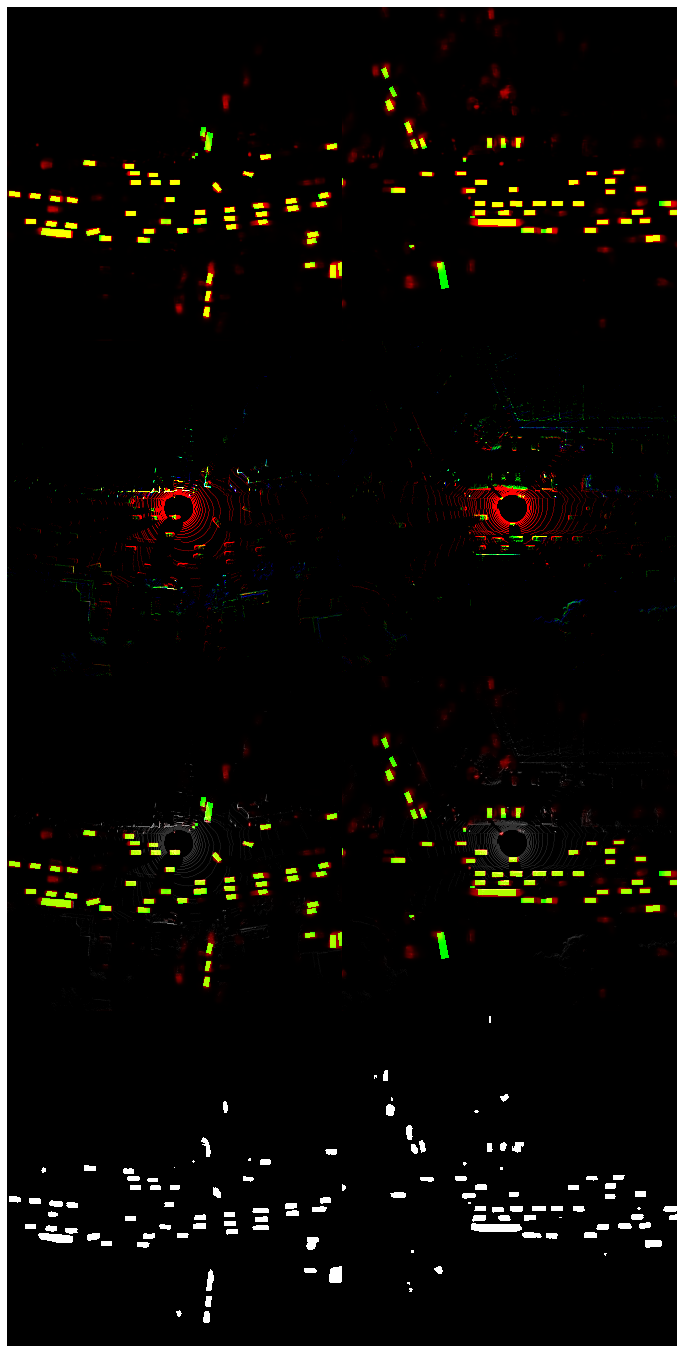


Loss: 0.034970004
Epoch 4


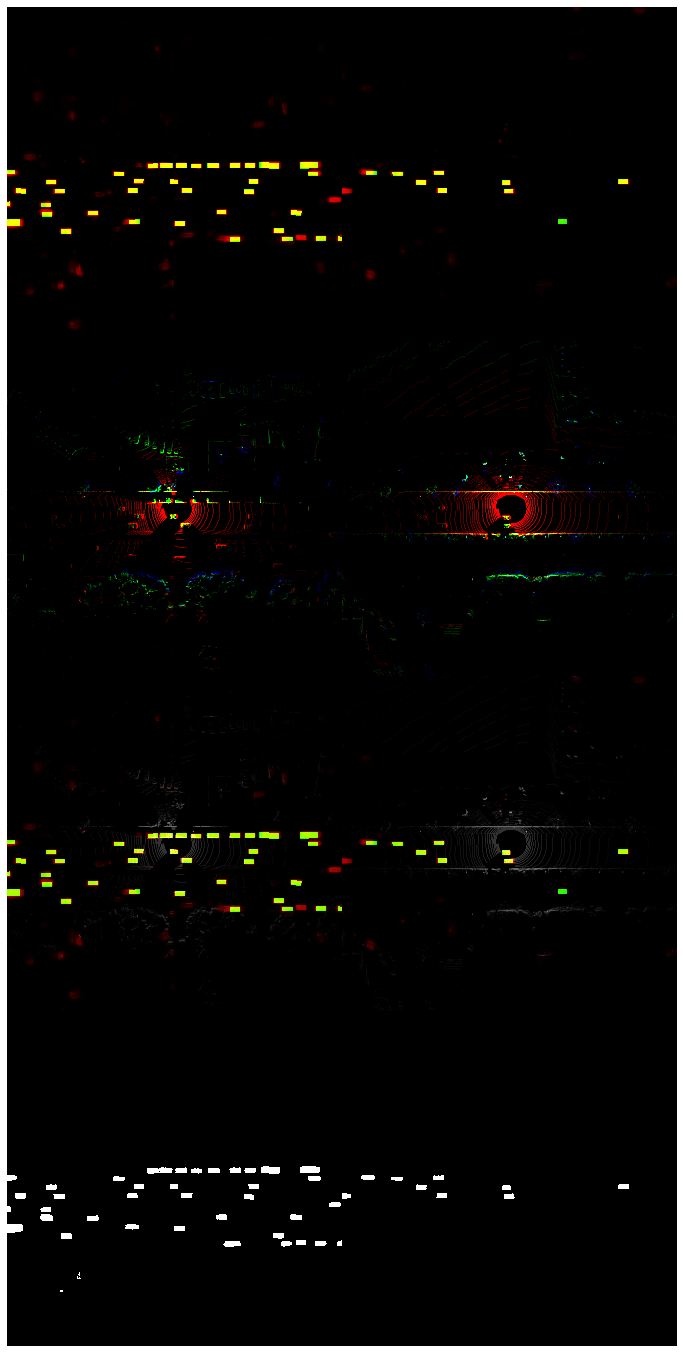


Loss: 0.031270072
Epoch 5


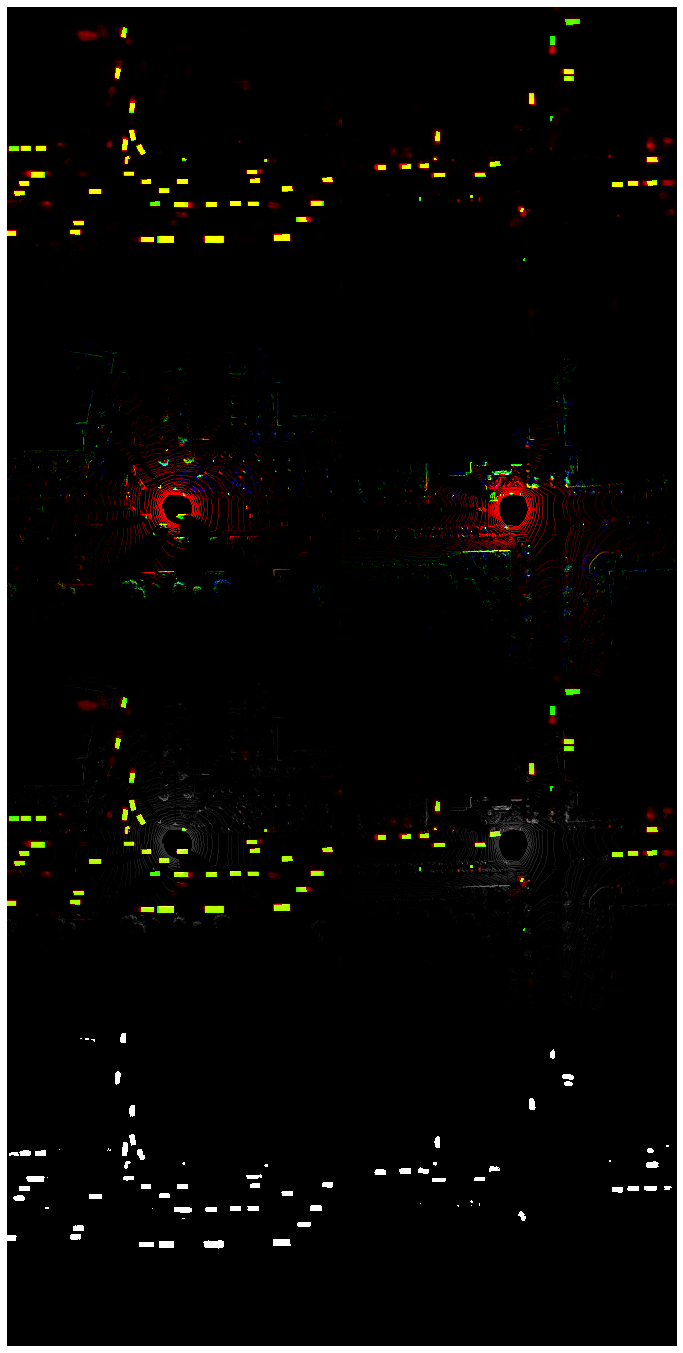


Loss: 0.028691342
Epoch 6


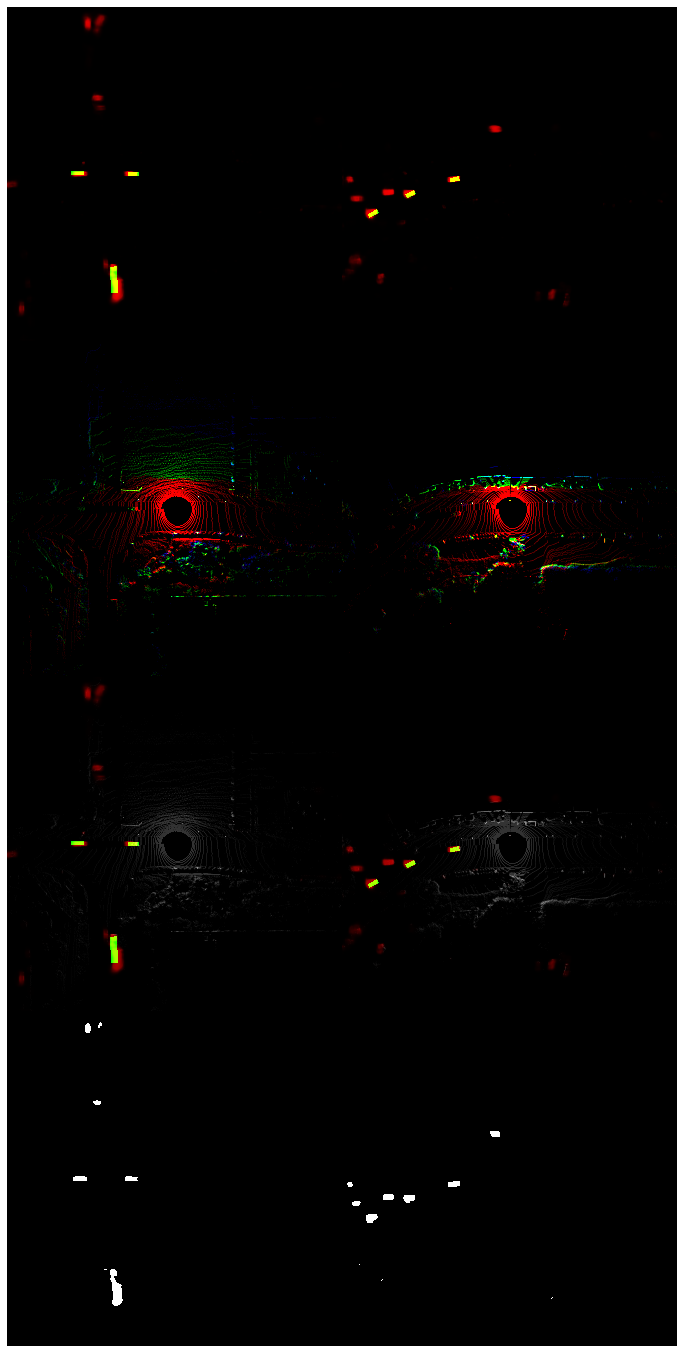


Loss: 0.026703078
Epoch 7


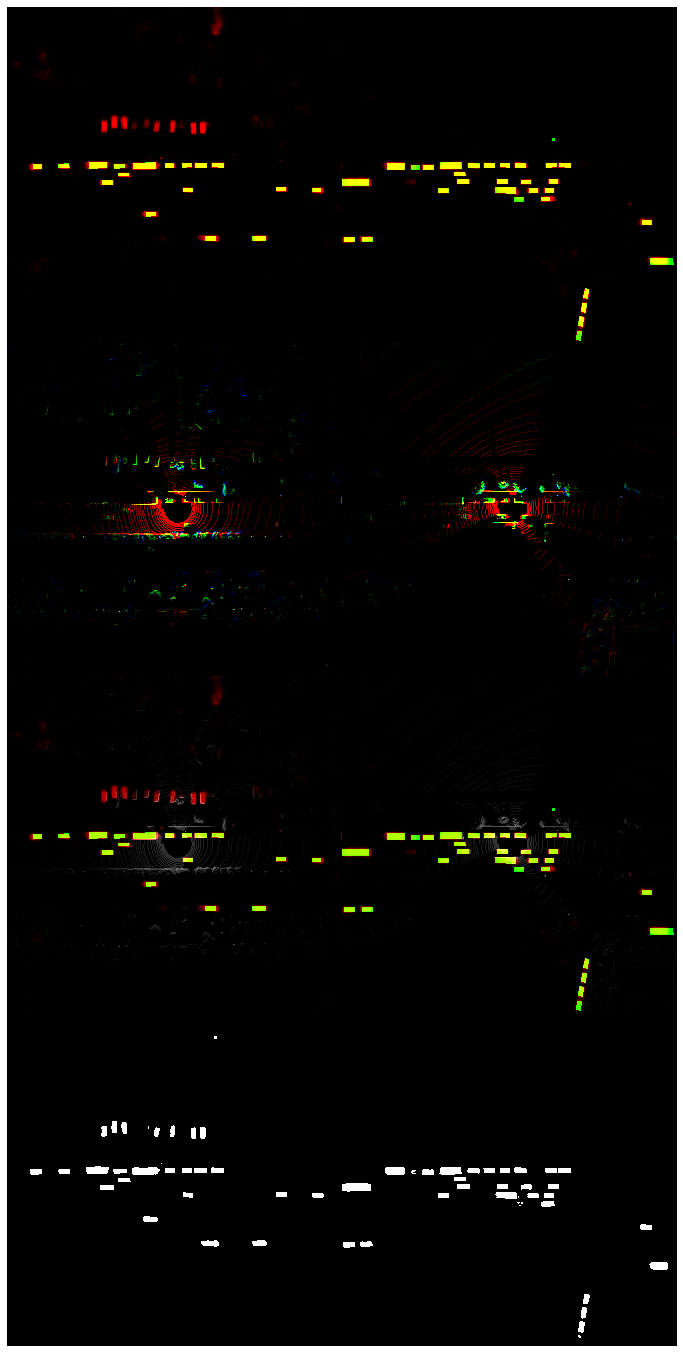


Loss: 0.025155598
Epoch 8


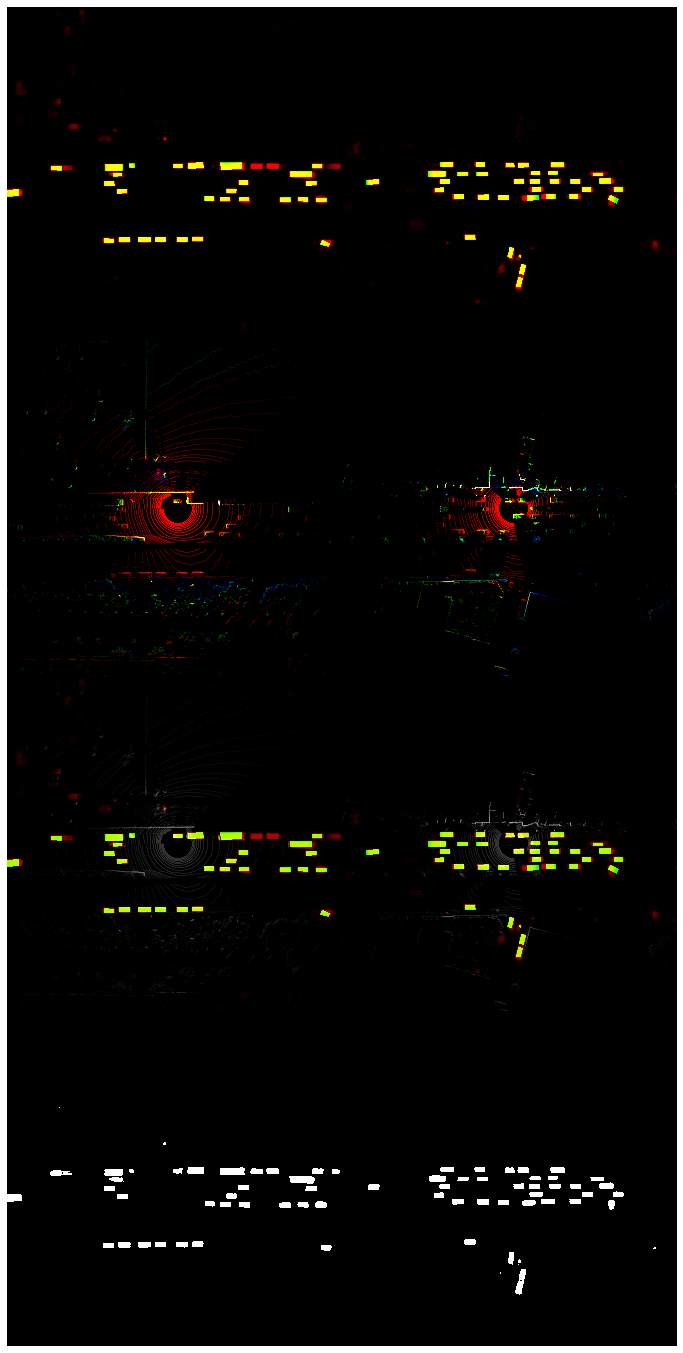


Loss: 0.024008058
Epoch 9


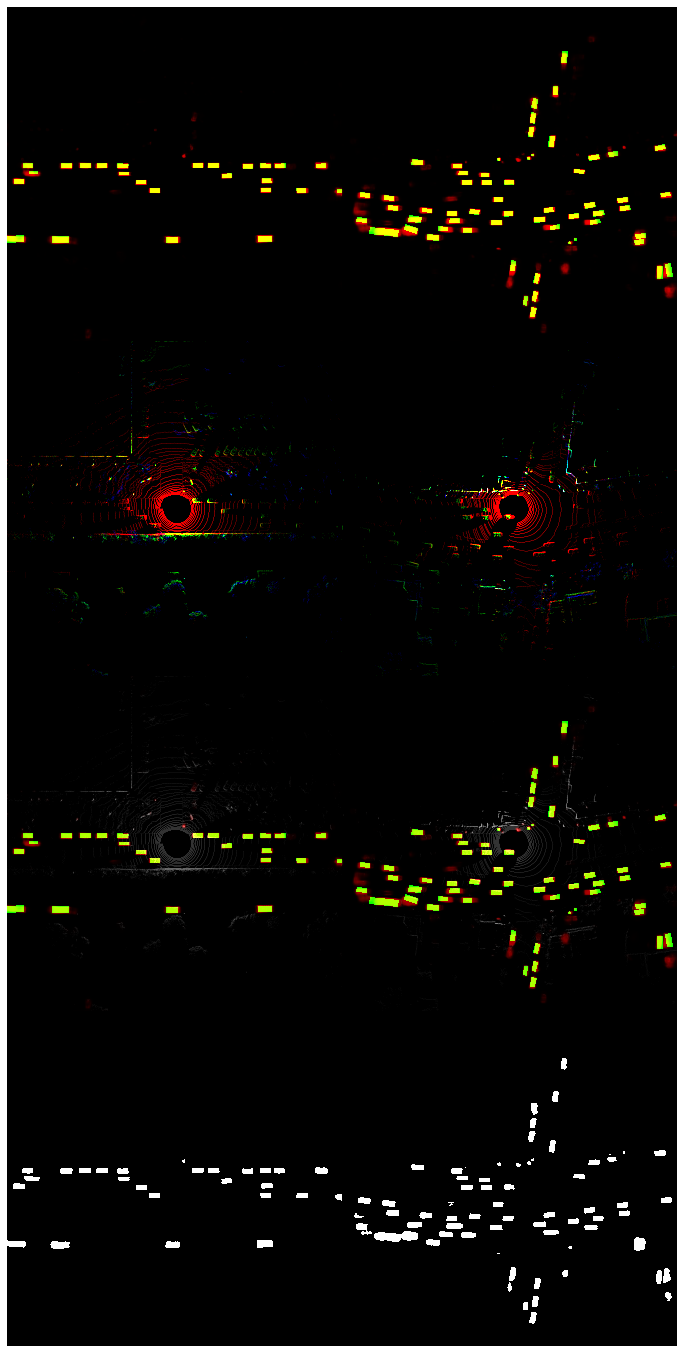


Loss: 0.023175413
Epoch 10


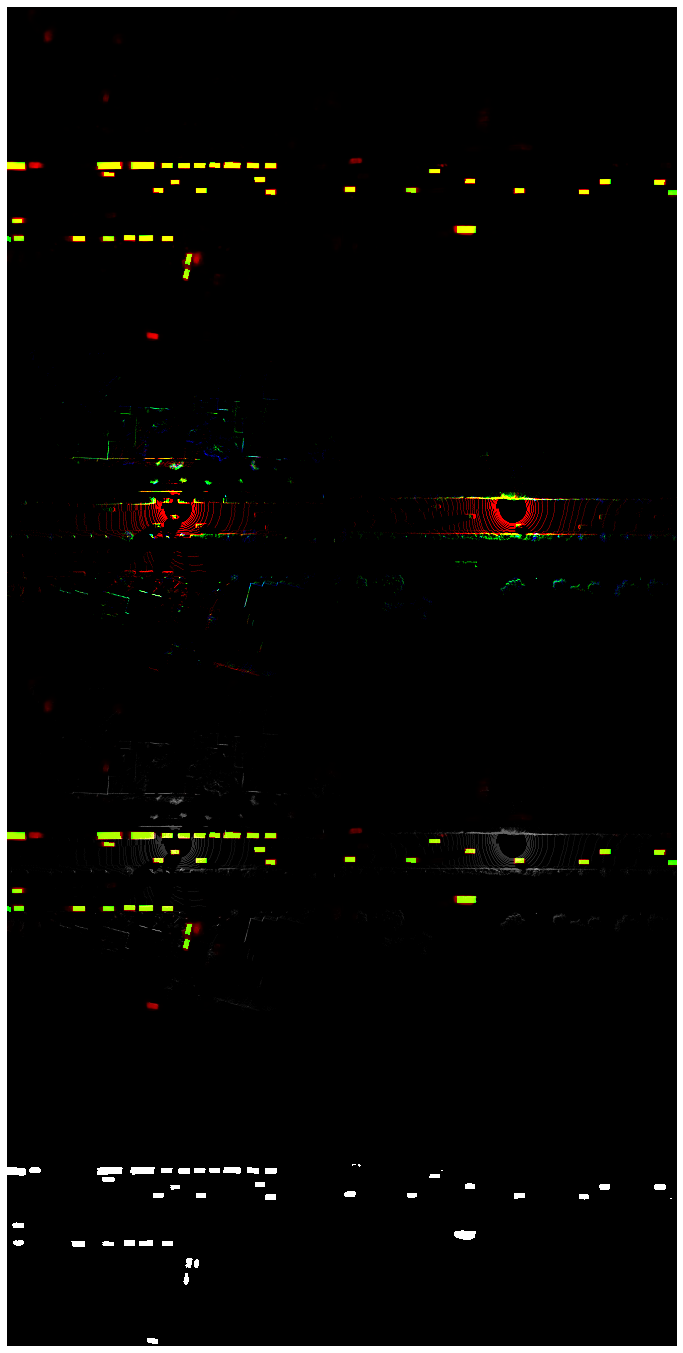


Loss: 0.022276772
Epoch 11


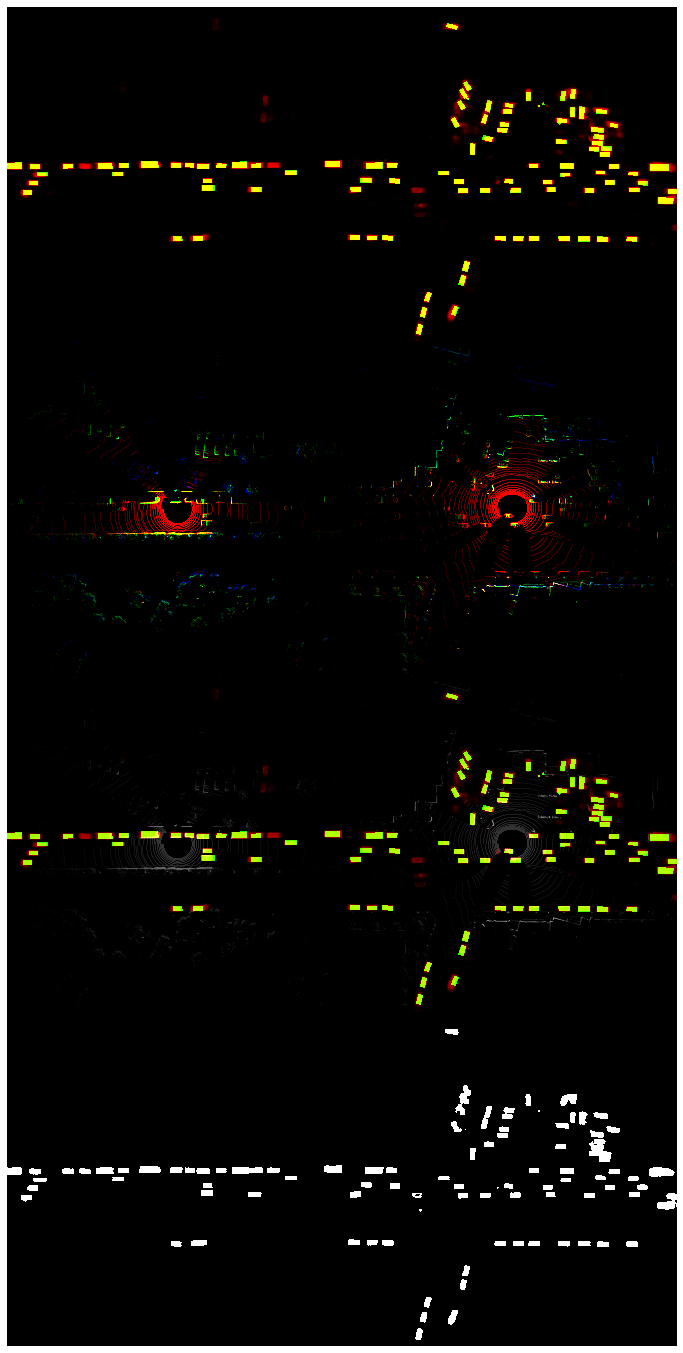


Loss: 0.021488657
Epoch 12


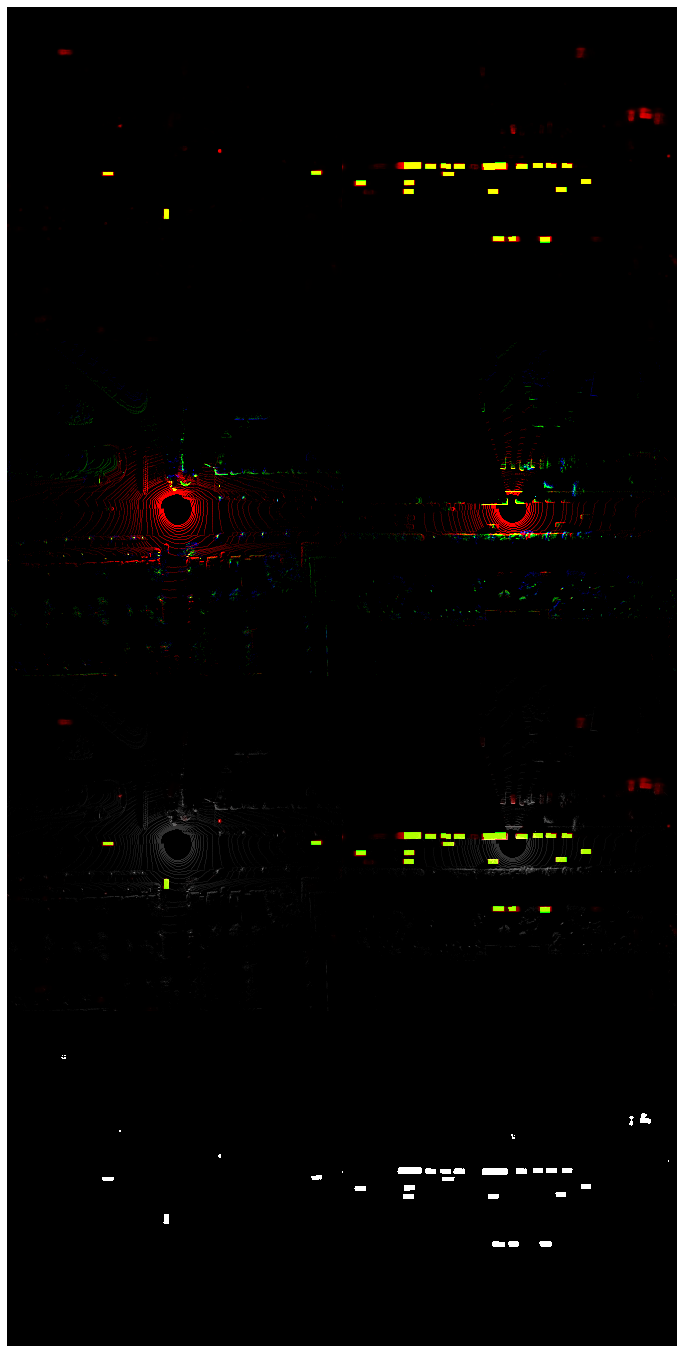


Loss: 0.020921884
Epoch 13


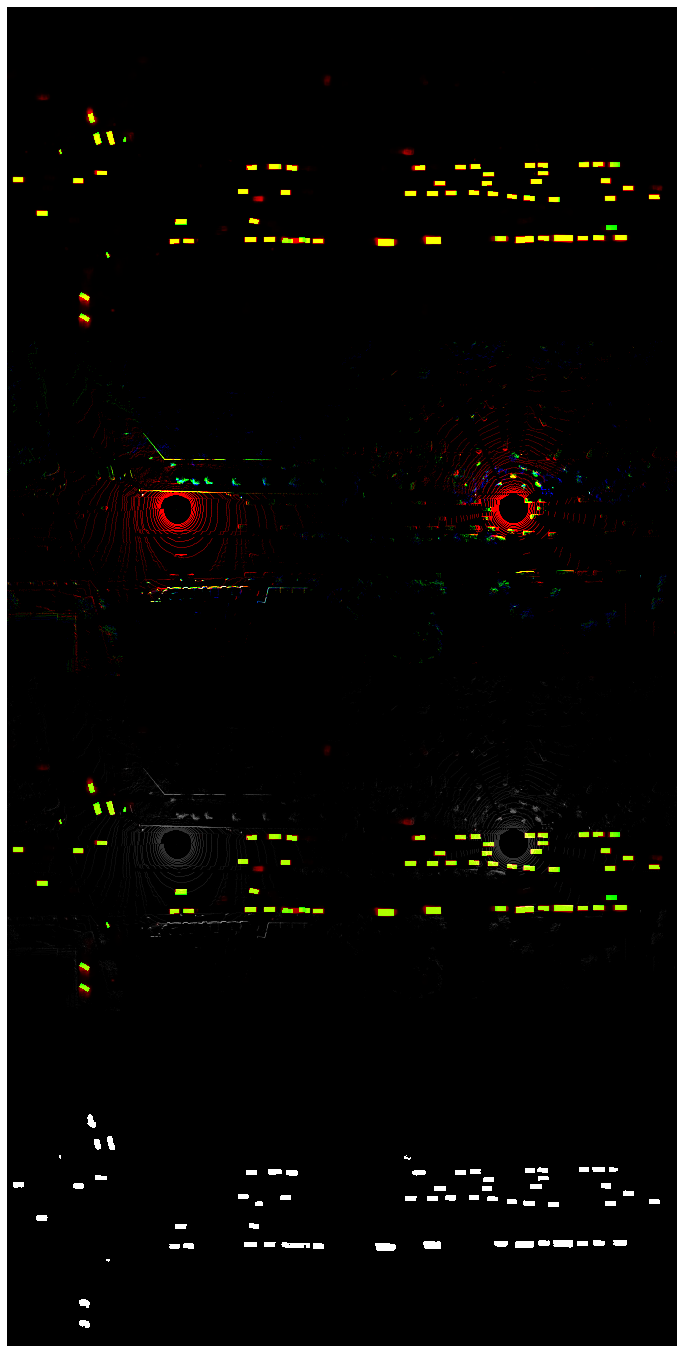


Loss: 0.020473635
Epoch 14


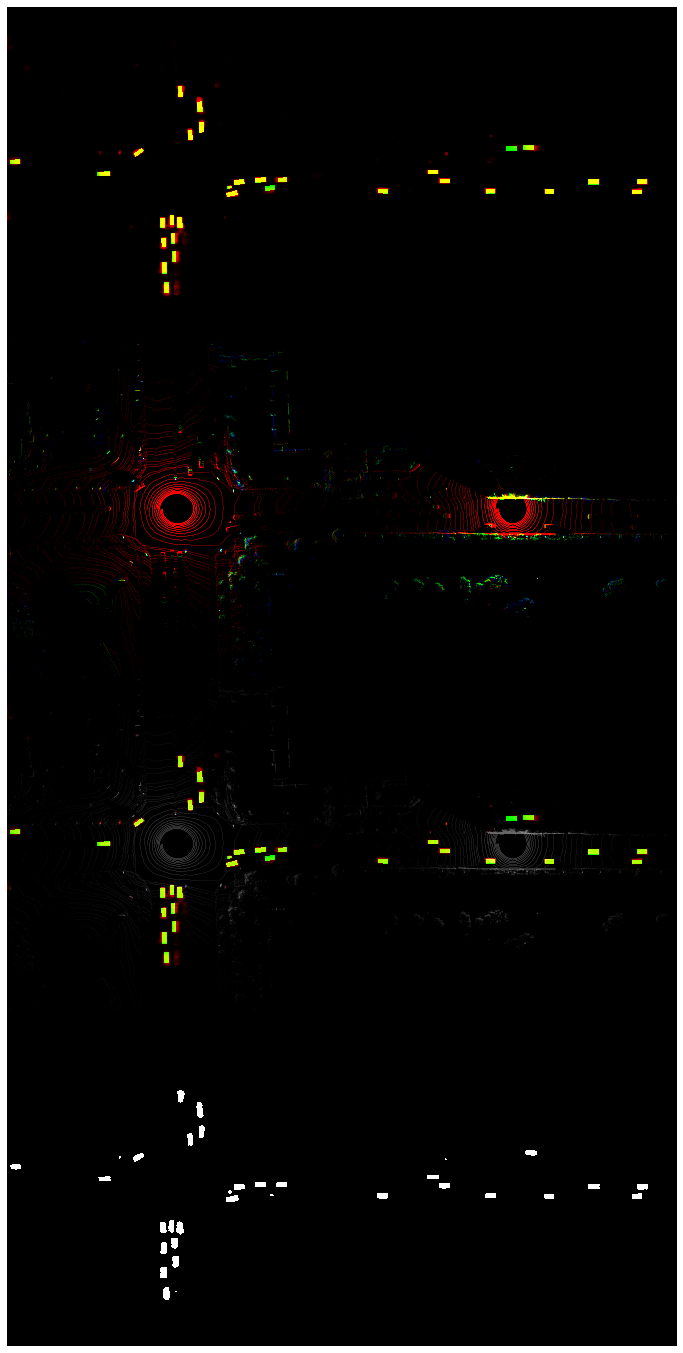


Loss: 0.019993111
Epoch 15


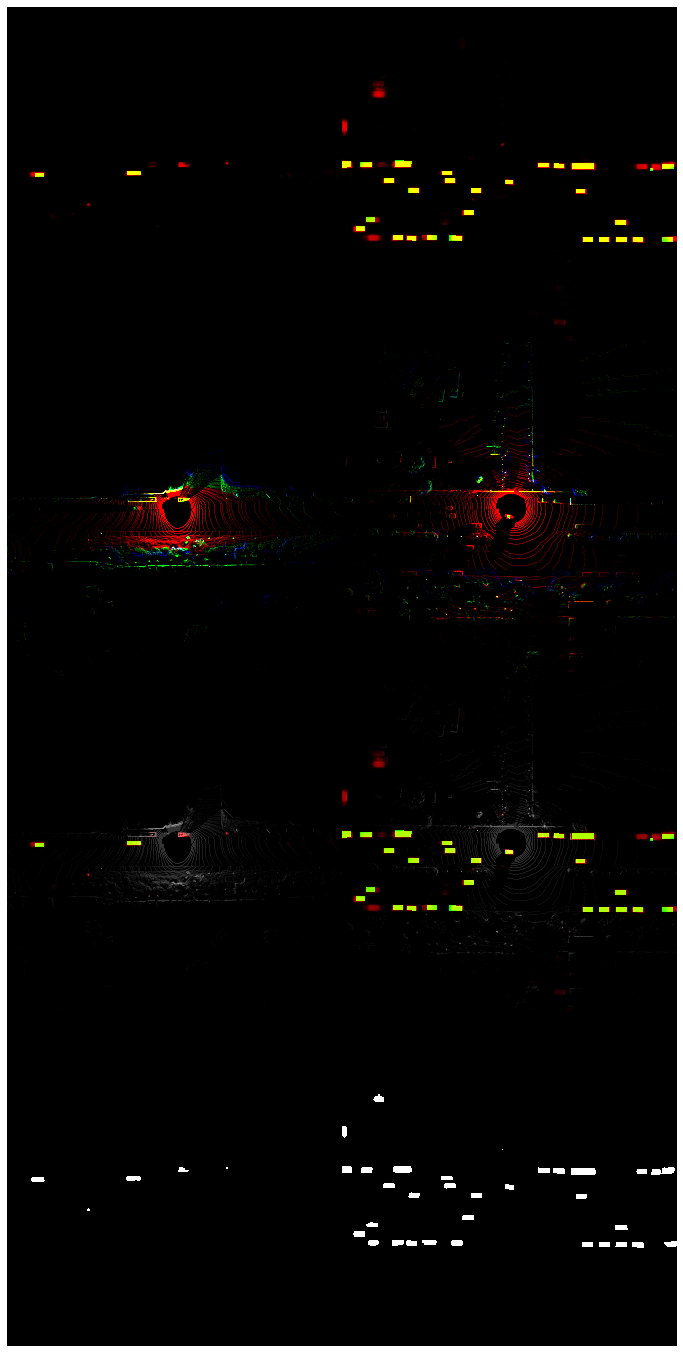


Loss: 0.019489197


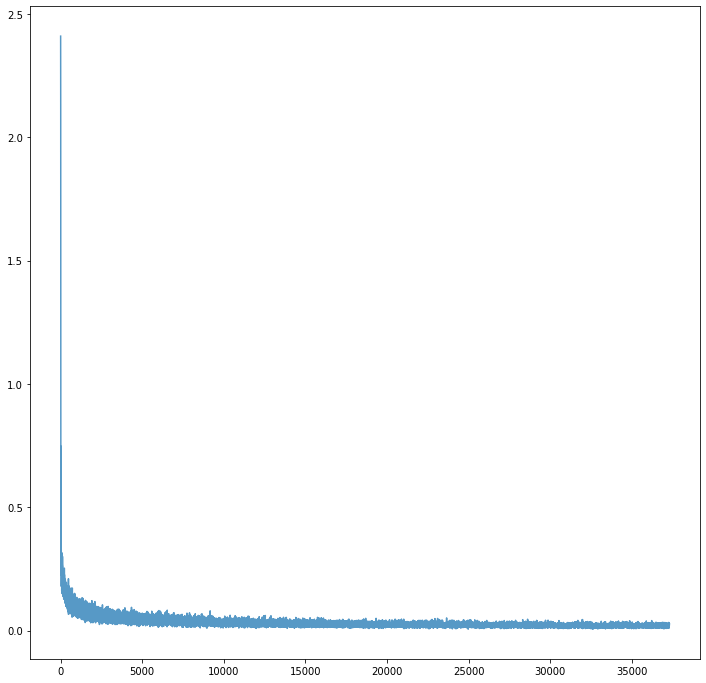

In [72]:
for epoch in range(1, epochs+1):
    print("Epoch", epoch)
    
    epoch_losses = []
    progress_bar = tqdm_notebook(dataloader)
    
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)

        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

        if ii == 0:
            visualize_predictions(X, prediction, target)
    
    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)
    
    checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join('./objects', checkpoint_filename)
    torch.save(model.state_dict(), checkpoint_filepath)
    
plt.figure(figsize=(12,12))
plt.plot(all_losses, alpha=0.75)
plt.show()

In [76]:
input_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(validation_data_folder, "*_target.png")))

batch_size=16
validation_dataset = BEVImageDataset(input_filepaths, target_filepaths)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_unet_model(num_output_classes=1+len(classes))
model = model.to(device)

epoch_to_load=15
checkpoint_filename = "unet_checkpoint_epoch_{}.pth".format(epoch_to_load)
checkpoint_filepath = os.path.join('./objects', checkpoint_filename)
model.load_state_dict(torch.load(checkpoint_filepath))

<All keys matched successfully>

In [77]:
progress_bar = tqdm_notebook(validation_dataloader)

targets = np.zeros((len(target_filepaths), 336, 336), dtype=np.uint8)

# We quantize to uint8 here to conserve memory. We're allocating >20GB of memory otherwise.
predictions = np.zeros((len(target_filepaths), 1+len(classes), 336, 336), dtype=np.uint8)

sample_tokens = []
all_losses = []

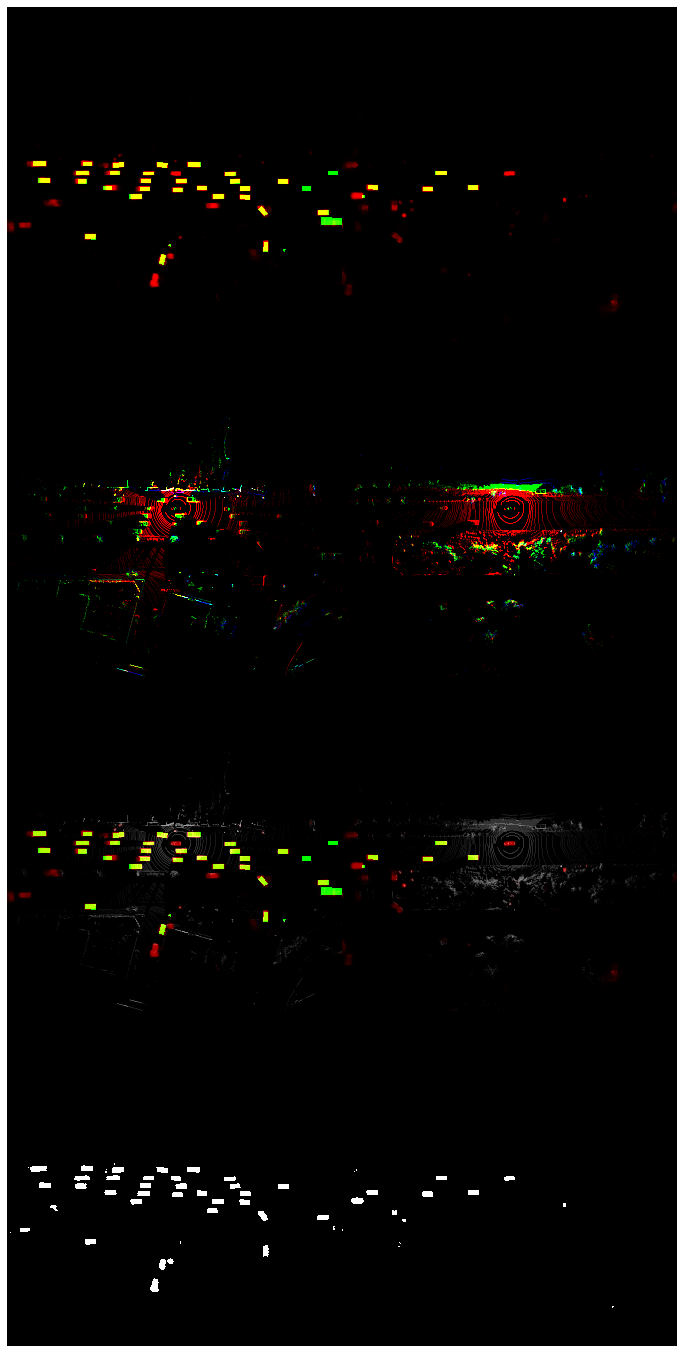

In [78]:
with torch.no_grad():
    model.eval()
    for ii, (X, target, batch_sample_tokens) in enumerate(progress_bar):

        offset = ii*batch_size
        targets[offset:offset+batch_size] = target.numpy()
        sample_tokens.extend(batch_sample_tokens)
        
        X = X.to(device)  # [N, 1, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction = model(X)  # [N, 2, H, W]
        loss = F.cross_entropy(prediction, target, weight=class_weights)
        all_losses.append(loss.detach().cpu().numpy())
        
        prediction = F.softmax(prediction, dim=1)
        
        prediction_cpu = prediction.cpu().numpy()
        predictions[offset:offset+batch_size] = np.round(prediction_cpu*255).astype(np.uint8)
        
        if ii == 0:
            visualize_predictions(X, prediction, target, apply_softmax=False)

In [79]:
print("Mean loss:", np.mean(all_losses))

Mean loss: 0.0845577


In [80]:
predictions_non_class0 = 255 - predictions[:,0]

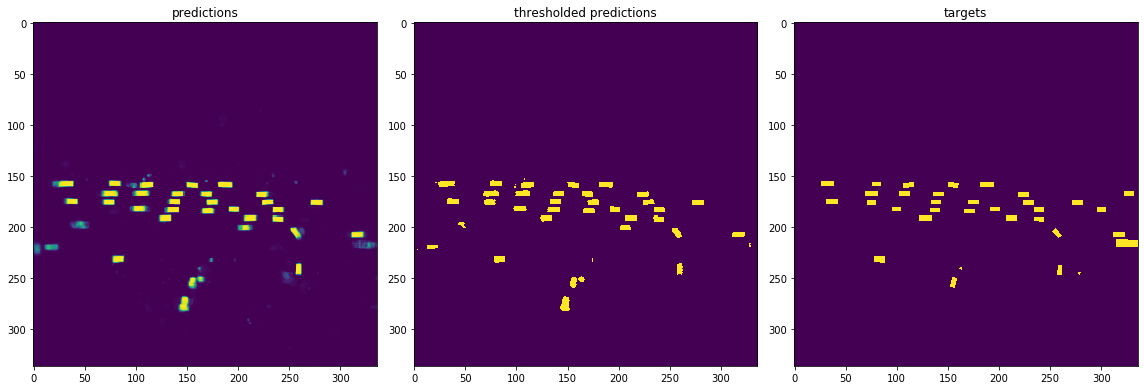

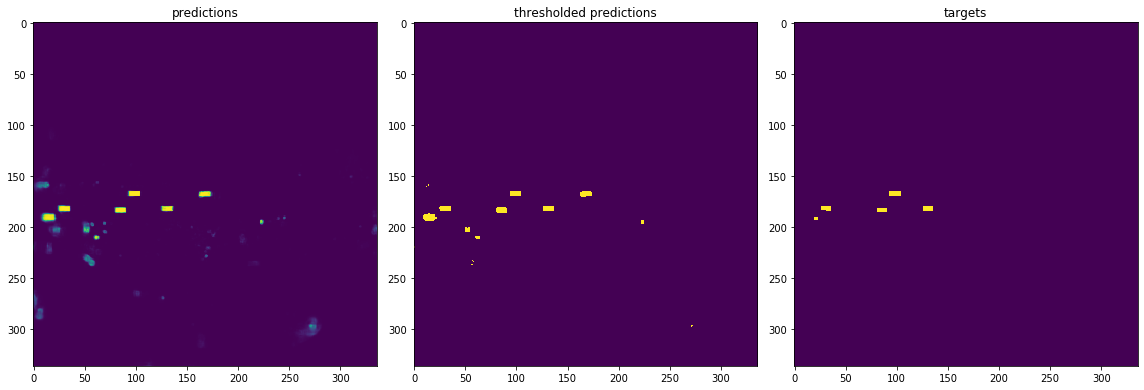

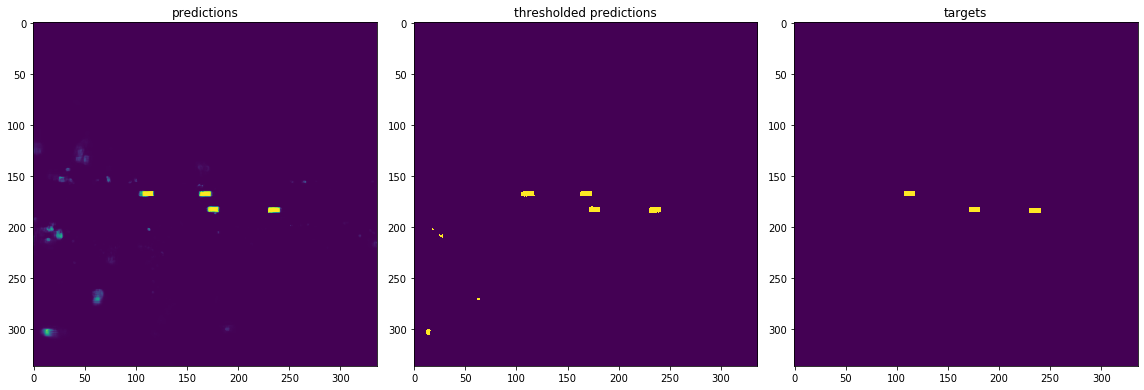

In [81]:
background_threshold = 255//2

for i in range(3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
    axes[0].imshow(predictions_non_class0[i])
    axes[0].set_title("predictions")
    axes[1].imshow(predictions_non_class0[i] > background_threshold)
    axes[1].set_title("thresholded predictions")
    axes[2].imshow((targets[i] > 0).astype(np.uint8), interpolation="nearest")
    axes[2].set_title("targets")
    fig.tight_layout()
    fig.show()

100%|██████████| 4032/4032 [00:00<00:00, 7199.08it/s]


<Figure size 864x864 with 0 Axes>

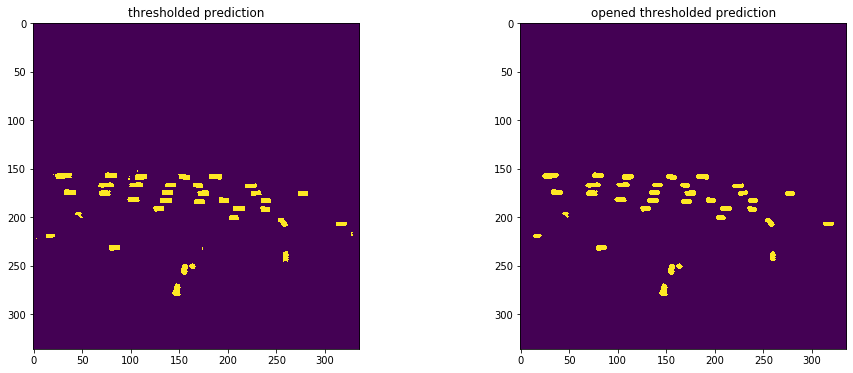

In [82]:
kernel = cv.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
predictions_opened = np.zeros((predictions_non_class0.shape), dtype=np.uint8)

for i, p in enumerate(tqdm(predictions_non_class0)):
    thresholded_p = (p > background_threshold).astype(np.uint8)
    predictions_opened[i] = cv.morphologyEx(thresholded_p, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(12,12))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].imshow(predictions_non_class0[0] > 255//2)
axes[0].set_title("thresholded prediction")
axes[1].imshow(predictions_opened[0])
axes[1].set_title("opened thresholded prediction")
fig.show()

In [83]:
detection_boxes = []
detection_scores = []
detection_classes = []

for i in tqdm_notebook(range(len(predictions))):
    prediction_opened = predictions_opened[i]
    probability_non_class0 = predictions_non_class0[i]
    class_probability = predictions[i]

    sample_boxes = []
    sample_detection_scores = []
    sample_detection_classes = []
    
    contours, hierarchy = cv2.findContours(prediction_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        
        # Let's take the center pixel value as the confidence value
        box_center_index = np.int0(np.mean(box, axis=0))
        
        for class_index in range(len(classes)):
            box_center_value = class_probability[class_index+1, box_center_index[1], box_center_index[0]]
            
            # Let's remove candidates with very low probability
            if box_center_value < 0.01:
                continue
            
            box_center_class = classes[class_index]

            box_detection_score = box_center_value
            sample_detection_classes.append(box_center_class)
            sample_detection_scores.append(box_detection_score)
            sample_boxes.append(box)
        
    
    detection_boxes.append(np.array(sample_boxes))
    detection_scores.append(sample_detection_scores)
    detection_classes.append(sample_detection_classes)

In [84]:
print("Total amount of boxes:", np.sum([len(x) for x in detection_boxes]))

Total amount of boxes: 139209


In [87]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision

def load_groundtruth_boxes(nuscenes, sample_tokens):
    gt_box3ds = []

    # Load annotations and filter predictions and annotations.
    for sample_token in tqdm_notebook(sample_tokens):
        sample = nuscenes.get('sample', sample_token)
        sample_annotation_tokens = sample['anns']

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = data.get("sample_data", sample_lidar_token)
        ego_pose = data.get("ego_pose", lidar_data["ego_pose_token"])
        ego_translation = np.array(ego_pose['translation'])
        
        for sample_annotation_token in sample_annotation_tokens:
            sample_annotation = nuscenes.get('sample_annotation', sample_annotation_token)
            sample_annotation_translation = sample_annotation['translation']
            
            class_name = sample_annotation['category_name']
            
            box3d = Box3D(
                sample_token=sample_token,
                translation=sample_annotation_translation,
                size=sample_annotation['size'],
                rotation=sample_annotation['rotation'],
                name=class_name
            )
            gt_box3ds.append(box3d)
            
    return gt_box3ds

gt_box3ds = load_groundtruth_boxes(data, sample_tokens)

In [93]:
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D, recall_precision
from scipy.spatial.transform import Rotation as R

pred_box3ds = []

for (sample_token, sample_boxes, sample_detection_scores, sample_detection_class) in tqdm_notebook(zip(sample_tokens, detection_boxes, detection_scores, detection_classes), total=len(sample_tokens)):
    sample_boxes = sample_boxes.reshape(-1, 2) # (N, 4, 2) -> (N*4, 2)
    sample_boxes = sample_boxes.transpose(1,0) # (N*4, 2) -> (2, N*4)

    # Add Z dimension
    sample_boxes = np.vstack((sample_boxes, np.zeros(sample_boxes.shape[1]),)) # (2, N*4) -> (3, N*4)

    sample = data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    lidar_data = data.get("sample_data", sample_lidar_token)
    lidar_filepath = data.get_sample_data_path(sample_lidar_token)
    ego_pose = data.get("ego_pose", lidar_data["ego_pose_token"])
    ego_translation = np.array(ego_pose['translation'])

    global_from_car = transform_matrix(ego_pose['translation'],
                                       Quaternion(ego_pose['rotation']), inverse=False)

    car_from_voxel = np.linalg.inv(transformation2voxel(bev_shape, voxel_size, (0, 0, z_offset)))


    global_from_voxel = np.dot(global_from_car, car_from_voxel)
    sample_boxes = transform(sample_boxes, global_from_voxel)

    # We don't know at where the boxes are in the scene on the z-axis (up-down), let's assume all of them are at
    # the same height as the ego vehicle.
    sample_boxes[2,:] = ego_pose["translation"][2]


    # (3, N*4) -> (N, 4, 3)
    sample_boxes = sample_boxes.transpose(1,0).reshape(-1, 4, 3)

#     box_height = 1.75
    box_height = np.array([mean_heights[cls] for cls in sample_detection_class])

    # Note: Each of these boxes describes the ground corners of a 3D box.
    # To get the center of the box in 3D, we'll have to add half the height to it.
    sample_boxes_centers = sample_boxes.mean(axis=1)
    sample_boxes_centers[:,2] += box_height/2

    # Width and height is arbitrary - we don't know what way the vehicles are pointing from our prediction segmentation
    # It doesn't matter for evaluation, so no need to worry about that here.
    # Note: We scaled our targets to be 0.8 the actual size, we need to adjust for that
    sample_lengths = np.linalg.norm(sample_boxes[:,0,:] - sample_boxes[:,1,:], axis=1) * 1/box_scale
    sample_widths = np.linalg.norm(sample_boxes[:,1,:] - sample_boxes[:,2,:], axis=1) * 1/box_scale
    
    sample_boxes_dimensions = np.zeros_like(sample_boxes_centers) 
    sample_boxes_dimensions[:,0] = sample_widths
    sample_boxes_dimensions[:,1] = sample_lengths
    sample_boxes_dimensions[:,2] = box_height

    for i in range(len(sample_boxes)):
        translation = sample_boxes_centers[i]
        size = sample_boxes_dimensions[i]
        class_name = sample_detection_class[i]
        ego_distance = float(np.linalg.norm(ego_translation - translation))
    
        
        # Determine the rotation of the box
        v = (sample_boxes[i,0] - sample_boxes[i,1])
        v /= np.linalg.norm(v)
        r = R.from_dcm([
            [v[0], -v[1], 0],
            [v[1],  v[0], 0],
            [   0,     0, 1],
        ])
        quat = r.as_quat()
        # XYZW -> WXYZ order of elements
        quat = quat[[3,0,1,2]]
        
        detection_score = float(sample_detection_scores[i])

        
        box3d = Box3D(
            sample_token=sample_token,
            translation=list(translation),
            size=list(size),
            rotation=list(quat),
            name=class_name,
            score=detection_score
        )
        pred_box3ds.append(box3d)

In [94]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
#     yaw = -np.arctan2(pred_box3ds[i].rotation[2], pred_box3ds[i].rotation[0])
    yaw = 2*np.arccos(pred_box3ds[i].rotation[0]);
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(yaw) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] += pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        